# Super Math Saga AB Test Report

Author: Guilherme Fernandes Ribeiro

## Executive Summary

<li>Each player in group B played, on average, 2 game rounds less than players in group A during the test period.</li><br><br>

<li>Taking into account only players that are used to purchase in-game items, this difference increases to 10.53 less game rounds in group B.</li><br><br>

<li>The average purchases by a player doesn't show significant differences between groups A and B during the test period.</li><br><br>

<li>The players that received the test (Group B) proven to be less engaged than players that didn't receive the test (Group A).</li>

## Data Analysis

This report will focus on the following metrics:<br>

&emsp;<li>Total number of game rounds played</li>
&emsp;<li>Total number of purchases</li>
&emsp;<li>Number of game rounds played by each player on average</li>
&emsp;<li>Number of purchases made by each player on average.</li><br>

For future works, analysis regarding the conversion rate, differences within groups in different periods (before and after the test period for instance) and others can be done with this data.<br>

To compare the control group A with the test group B, this work will use statistical tests to check if the difference between the mean of the metrics chosen is statistically significant. That means, if the differences are not due by chances.<br>

Since the data provided is very large (7.2GB in activity table), the analysis will be done by taking a sample.

### Coding setup

In [91]:
# Importing libraries

from google.cloud import bigquery

import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns 

from scipy import stats

In [74]:
# Configure objects
client = bigquery.Client()

job_config = bigquery.QueryJobConfig()
job_config.use_legacy_sql = False

c:\users\guilherme\appdata\local\programs\python\python36\lib\site-packages\google\auth\_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [93]:
### Constants
# Assignment table name
assignment_table = 'abtest.assignment'
# Activity table name
activity_table = 'abtest.activity'

# Test group names
a_group = 'A'
b_group = 'B'

# Number of users in sample
sample_size = 50000

### SQL Queries
# Query for sample the players in groups A and B
sample_assignment = ('SELECT playerid, assignment_date, install_date, conversion_date '
                    'FROM {0} '
                    'WHERE abtest_group = \'{1}\' '
                    'ORDER BY RAND() LIMIT {3}')
# Replace values for Group A query
query_sample_assignment_a = sample_assignment.format(assignment_table, a_group, random_seed, sample_size)
# Replace values for Group B query
query_sample_assignment_b = sample_assignment.format(assignment_table, b_group, random_seed, sample_size)

# Query for return the activity of the sampled players from 2017-05-04 to 2017-05-22 (test period)
query_sample_activity = ('SELECT playerid, activity_date, purchases, gameends '
                         'FROM ' + activity_table + ' '
                         'WHERE playerid IN UNNEST(@players) '
                         'AND activity_date >= \'2017-05-04\' AND activity_date <= \'2017-05-22\' '
                         'LIMIT 550000')

### Retrieving data from server

In [37]:
# Data frame with group A players sample
sample_assign_a_df = client.query(query_sample_assignment_a).to_dataframe()

In [38]:
# Data frame with group B players sample
sample_assign_b_df = client.query(query_sample_assignment_b).to_dataframe()

In [94]:
query_params_a = [
    bigquery.ArrayQueryParameter("players", "INT64", sample_assign_a_df['playerid'].to_list())
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params_a
job_config.use_legacy_sql = False

# Data frame with group A players activity sample
sample_activity_a_df = client.query(query_sample_activity, job_config = job_config).to_dataframe()

In [96]:
query_params_b = [
    bigquery.ArrayQueryParameter("players", "INT64", sample_assign_b_df['playerid'].to_list())
]

job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params_b
job_config.use_legacy_sql = False

# Data frame with group B players activity sample
sample_activity_b_df = client.query(query_sample_activity, job_config = job_config).to_dataframe()

### Data profiling

In [95]:
# Group A players sample profile
sample_assign_a_df.profile_report()

In [40]:
# Group B players sample profile
sample_assign_b_df.profile_report()

In [97]:
# Group A players activity profile
sample_activity_a_df.profile_report()

In [98]:
# Group B players activity profile
sample_activity_b_df.profile_report()

## T-test assumptions check

In order to check if the differences in the metrics for both groups (A and B) are statistically relevant, the Student's T-Test will be used.

However, the Student's T-Test can only be used if its assumptions are met. Otherwise, another statistical test will be applied.

### Variable: gameends

#### Homogeneity of Variances

In [99]:
stats.levene(sample_activity_a_df['gameends'], sample_activity_b_df['gameends'])

LeveneResult(statistic=3.06054439310035, pvalue=0.08021506906722746)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the variable 'gameends' for group A and B.

#### Normal distribution of residuals

Text(0.5, 1.0, 'Number of game rounds played P-P plot')

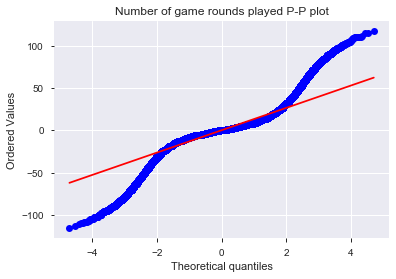

In [116]:
gameend_diff = sample_activity_a_df['gameends'].sort_values() - sample_activity_b_df['gameends'].sort_values()

stats.probplot(gameend_diff, plot = plt)
plt.title('Number of game rounds played P-P plot')

The plot above shows us that the residuals are NOT normally distributed. Hence, the independent t-test is not suitable.
We should use the Mann-Whitney U Test instead since it is a non-parametric test.

### Test for difference between number of game rounds in groups A and B

In [118]:
gameends_a_mean = sample_activity_a_df['gameends'].mean()
gameends_b_mean = sample_activity_b_df['gameends'].mean()

print('Average number of game round played in group A: ', gameends_a_mean)
print('Average number of game round played in group B: ', gameends_b_mean)
print('Difference: ', gameends_a_mean - gameends_b_mean)

Average number of game round played in group A:  13.138887272727272
Average number of game round played in group B:  12.96193090909091
Difference:  0.17695636363636247


In [110]:
stats.mannwhitneyu(sample_activity_a_df['gameends'], sample_activity_b_df['gameends'])

MannwhitneyuResult(statistic=148108489742.5, pvalue=5.517122417516017e-80)

The Mann-Whitney U Test shows us a P-Value < 0.05. Hence, the means in group A and B for 'gameends' variable are considered statistically different.
However, the difference is very small (0.177 fewer game rounds in group B on average)

### Variable: purchases

#### Homogeneity of Variances

In [123]:
stats.levene(sample_activity_a_df['purchases'], sample_activity_b_df['purchases'])

LeveneResult(statistic=1.1184148628095507, pvalue=0.29026026305643693)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the variable 'purchases' for group A and B.

#### Normal distribution of residuals

Text(0.5, 1.0, 'Number of purchases P-P plot')

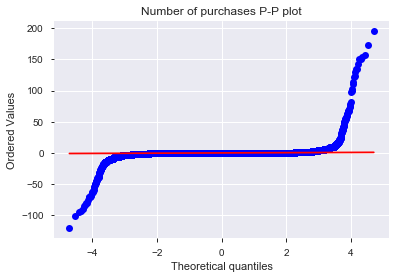

In [124]:
purchases_diff = sample_activity_a_df['purchases'].sort_values() - sample_activity_b_df['purchases'].sort_values()

stats.probplot(purchases_diff, plot = plt)
plt.title('Number of purchases P-P plot')

The plot above shows us that the residuals are NOT normally distributed. Hence, the independent t-test is not suitable. We should use the Mann-Whitney U Test instead

### Test for difference between number of purchases in groups A and B

In [125]:
purchases_a_mean = sample_activity_a_df['purchases'].mean()
purchases_b_mean = sample_activity_b_df['purchases'].mean()

print('Average number of purchases in group A: ', purchases_a_mean)
print('Average number of purchases in group B: ', purchases_b_mean)
print('Difference: ', purchases_a_mean - purchases_b_mean)

Average number of purchases in group A:  0.03235818181818182
Average number of purchases in group B:  0.0307
Difference:  0.001658181818181819


In [126]:
stats.mannwhitneyu(sample_activity_a_df['purchases'], sample_activity_b_df['purchases'])

MannwhitneyuResult(statistic=151151311238.0, pvalue=0.0009129176653403788)

The Mann-Whitney U Test shows us a P-Value < 0.05. Hence, the means in group A and B for 'purchases' variable are considered statistically different. However, the difference is very small (0.0016 fewer purchases in group B on average)

### Variable: Total game rounds played by each player (new variable)

In [141]:
# Calculating total games played by each player during the test period
games_per_player_a = sample_activity_a_df.groupby('playerid')['gameends'].sum()
games_per_player_b = sample_activity_b_df.groupby('playerid')['gameends'].sum()

#### Homogeneity of Variances

In [135]:
stats.levene(games_per_player_a, games_per_player_b)

LeveneResult(statistic=1.253815486275047, pvalue=0.26282769732909894)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the total games round played variable for group A and B.

#### Normal distribution of the variables

Text(0.5, 1.0, 'Number of game round played by each player (Group A) P-P plot')

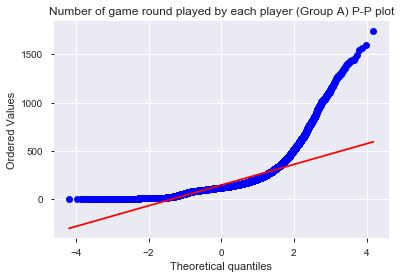

In [179]:
stats.probplot(games_per_player_a, plot = plt)
plt.title('Number of game round played by each player (Group A) P-P plot')

Text(0.5, 1.0, 'Number of game round played by each player (Group B) P-P plot')

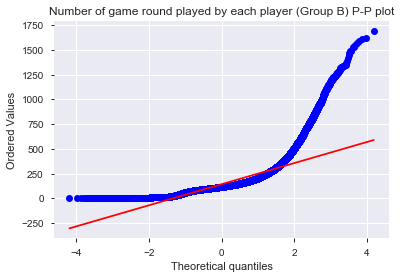

In [180]:
stats.probplot(games_per_player_b, plot = plt)
plt.title('Number of game round played by each player (Group B) P-P plot')

None of both groups has a normal distribution. Hence, the independent t-test is not suitable. We should use the Mann-Whitney U Test instead

### Test for difference between the average of game round played by each player in groups A and B

In [142]:
games_per_player_a_mean = games_per_player_a.mean()
games_per_player_b_mean = games_per_player_b.mean()

print('Average game round played by player in group A: ', games_per_player_a_mean)
print('Average game round played by player in group B: ', games_per_player_b_mean)
print('Difference: ', games_per_player_a_mean - games_per_player_b_mean)

Average game round played by player in group A:  145.5495176136478
Average game round played by player in group B:  143.54008778641324
Difference:  2.0094298272345554


In [143]:
stats.mannwhitneyu(games_per_player_a, games_per_player_b)

MannwhitneyuResult(statistic=1209996053.0, pvalue=1.9122166567760655e-07)

The Mann-Whitney U Test shows us a P-Value < 0.05. Hence, the averages of total game round played by a player in group A and B are considered statistically different. 

<b>In this case, the players in group B played, on average, 2 game rounds less than group A during the test period (from 04/05/2017 to 22/05/2017)</b>

Since it is a significant difference, the next sections will go deeper into this metric.<br> The players are going to be split into two types:<br><br>
    &emsp;1- players that do not purchase items<br>
    &emsp;2- players that purchase items

### Variable: Total game rounds played by each player that does not purchase items (new variable)

In [153]:
# Calculating total games played by each player that doesn't purchase items

game_player_no_purchase_a = sample_activity_a_df.groupby('playerid').sum()
game_player_no_purchase_a = game_player_no_purchase_a.loc[game_player_no_purchase_a['purchases'] == 0, 'gameends']

game_player_no_purchase_b = sample_activity_b_df.groupby('playerid').sum()
game_player_no_purchase_b = game_player_no_purchase_b.loc[game_player_no_purchase_b['purchases'] == 0, 'gameends']

#### Homogeneity of Variances

In [156]:
stats.levene(game_player_no_purchase_a, game_player_no_purchase_b)

LeveneResult(statistic=0.9511639130649957, pvalue=0.32942565027749693)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the this variable for group A and B

#### Normal distribution of the variables

Text(0.5, 1.0, 'Number of game rounds by player that does not purchase items (Group A) P-P plot')

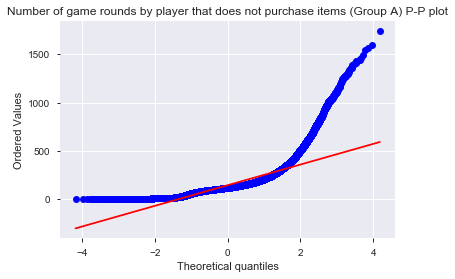

In [157]:
stats.probplot(game_player_no_purchase_a, plot = plt)
plt.title('Number of game rounds by player that does not purchase items (Group A) P-P plot')

Text(0.5, 1.0, 'Number of game rounds by player that does not purchase items (Group B) P-P plot')

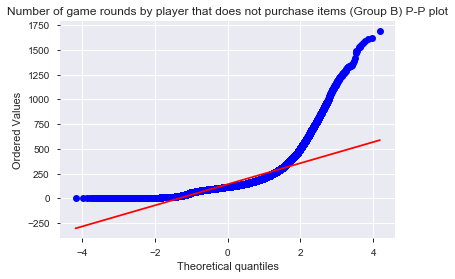

In [158]:
stats.probplot(game_player_no_purchase_b, plot = plt)
plt.title('Number of game rounds by player that does not purchase items (Group B) P-P plot')

None of both groups has a normal distribution. Hence, the independent t-test is not suitable. We should use the Mann-Whitney U Test instead

### Test for difference between the average of total game rounds played by each player that does not purchase items in groups A and B

In [159]:
game_player_no_purchase_a_mean = game_player_no_purchase_a.mean()
game_player_no_purchase_b_mean = game_player_no_purchase_b.mean()

print('Average total game rounds played by player that does not purchase items in group A: ', game_player_no_purchase_a_mean)
print('Average total game rounds played by player that does not purchase items in group B: ', game_player_no_purchase_b_mean)
print('Difference: ', game_player_no_purchase_a_mean - game_player_no_purchase_b_mean)

Average total game rounds played by player that does not purchase items in group A:  145.1157544302227
Average total game rounds played by player that does not purchase items in group B:  143.3240759902322
Difference:  1.7916784399905055


In [160]:
stats.mannwhitneyu(game_player_no_purchase_a, game_player_no_purchase_b)

MannwhitneyuResult(statistic=1147731858.5, pvalue=8.995561937054839e-07)

The Mann-Whitney U Test shows us a P-Value < 0.05. Hence, the averages of total game round played by a player that does not purchase items in group A and B are considered statistically different.

<b>In this case, the players in group B played, on average, 1.79 game rounds less than group A during the test period (from 04/05/2017 to 22/05/2017).</b><br>

### Variable: Total game rounds played by each player that purchases items (new variable)

In [161]:
# Calculating total games played by each player that purchases items

game_player_purchase_a = sample_activity_a_df.groupby('playerid').sum()
game_player_purchase_a = game_player_purchase_a.loc[game_player_purchase_a['purchases'] > 0, 'gameends']

game_player_purchase_b = sample_activity_b_df.groupby('playerid').sum()
game_player_purchase_b = game_player_purchase_b.loc[game_player_purchase_b['purchases'] > 0, 'gameends']

#### Homogeneity of Variances

In [163]:
stats.levene(game_player_purchase_a, game_player_purchase_b)

LeveneResult(statistic=0.7708444164998026, pvalue=0.38003615010378056)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the this variable for group A and B

#### Normal distribution of the variables

Text(0.5, 1.0, 'Number of game rounds by player that purchases items (Group A) P-P plot')

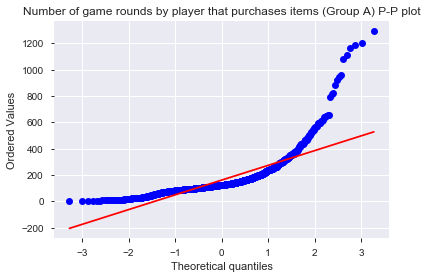

In [171]:
stats.probplot(game_player_purchase_a, plot = plt)
plt.title('Number of game rounds by player that purchases items (Group A) P-P plot')

Text(0.5, 1.0, 'Number of game rounds by player that purchases items (Group B) P-P plot')

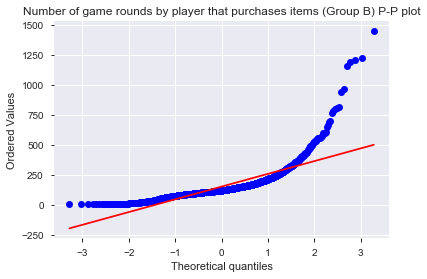

In [170]:
stats.probplot(game_player_purchase_b, plot = plt)
plt.title('Number of game rounds by player that purchases items (Group B) P-P plot')

None of both groups has a normal distribution. Hence, the independent t-test is not suitable. We should use the Mann-Whitney U Test instead

### Test for difference between the average of total game rounds played by each player that purchases items in groups A and B

In [166]:
game_player_purchase_a_mean = game_player_purchase_a.mean()
game_player_purchase_b_mean = game_player_purchase_b.mean()

print('Average total game rounds played by player that purchases items in group A: ', game_player_purchase_a_mean)
print('Average total game rounds played by player that purchases items in group B: ', game_player_purchase_b_mean)
print('Difference: ', game_player_purchase_a_mean - game_player_purchase_b_mean)

Average total game rounds played by player that purchases items in group A:  161.8361801242236
Average total game rounds played by player that purchases items in group B:  151.30654761904762
Difference:  10.529632505175982


In [169]:
stats.mannwhitneyu(game_player_purchase_a, game_player_purchase_b)

MannwhitneyuResult(statistic=818389.5, pvalue=0.007778714848934683)

The Mann-Whitney U Test shows us a P-Value < 0.05. Hence, the averages of total game round played by a player that purchases items in group A and B are considered statistically different.

<b>In this case, the players in group B played, on average, 10.53 game rounds less than group A during the test period (from 04/05/2017 to 22/05/2017).</b>

### Variable: Total purchases by each player (new variable)

In [173]:
# Calculating total purchases by each player

purchases_per_player_a = sample_activity_a_df.groupby('playerid').sum()
purchases_per_player_a = purchases_per_player_a.loc[purchases_per_player_a['purchases'] > 0, 'purchases']

purchases_per_player_b = sample_activity_b_df.groupby('playerid').sum()
purchases_per_player_b = purchases_per_player_b.loc[purchases_per_player_b['purchases'] > 0, 'purchases']

#### Homogeneity of Variances

In [174]:
stats.levene(purchases_per_player_a, purchases_per_player_b)

LeveneResult(statistic=0.2766104308618381, pvalue=0.5989758589371362)

The result above shows us a P-Value > 0.05. Therefore, there is homogeneity of variances in the total purchases for each player variable for group A and B.

#### Normal distribution of the variables

Text(0.5, 1.0, 'Number of purchases by player (Group A) P-P plot')

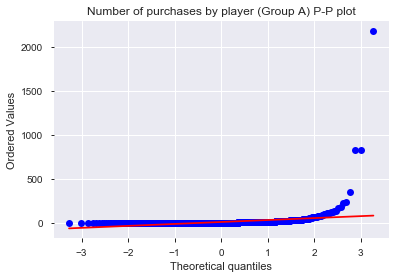

In [175]:
stats.probplot(purchases_per_player_a, plot = plt)
plt.title('Number of purchases by player (Group A) P-P plot')

Text(0.5, 1.0, 'Number of purchases by player (Group B) P-P plot')

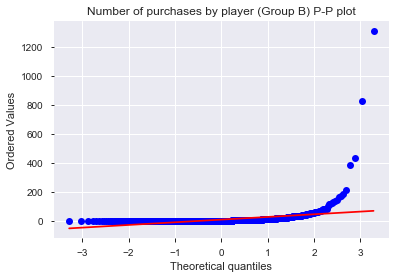

In [176]:
stats.probplot(purchases_per_player_b, plot = plt)
plt.title('Number of purchases by player (Group B) P-P plot')

None of both groups has a normal distribution. Hence, the independent t-test is not suitable. We should use the Mann-Whitney U Test instead

### Test for difference between the average of purchases by each player in groups A and B

In [177]:
purchases_per_player_a_mean = purchases_per_player_a.mean()
purchases_per_player_b_mean = purchases_per_player_b.mean()

print('Average purchase by player in group A: ', purchases_per_player_a_mean)
print('Average purchase by player in group B: ', purchases_per_player_b_mean)
print('Difference: ', purchases_per_player_a_mean - purchases_per_player_b_mean)

Average purchase by player in group A:  13.817546583850932
Average purchase by player in group B:  12.563244047619047
Difference:  1.2543025362318847


In [178]:
stats.mannwhitneyu(purchases_per_player_a, purchases_per_player_b)

MannwhitneyuResult(statistic=865214.0, pvalue=0.4933972668770768)

The Mann-Whitney U Test shows us a P-Value > 0.05. Hence, the averages of purchases by a player in group A and B are considered statistically equal during the test period.

## Conclusions

This work showed that the players that received the change in the Super Math Saga game happen to have, on average, 2 game rounds played less than the players that didn't receive the change.<br>
This difference gets even bigger if we check only players that are "in-game buyers". They played 10.53 game rounds less than the other group on average.<br><br>
The number of purchases, on the other hand, did not show a significant difference between the two groups. Therefore, the change made in the game did not affect the users buying behavior.<br><br>
Given this, I would guess that the change made in the Super Math Saga game is not related with 'item purchase journey' of the user and it is probably related to the difficulty of the levels.